# Orlen fuel prices analysis
Projekt ma na celu porównanie hurtowych cen paliw oferowanych w Polsce z cenami zakupu ropy brent oraz kursem USD/PLN. Ma to na celu określenie zmian cen paliw na rynku Polskim w odniesieniu do zmian gospodarczych, a także stwierdzeniu czy występują okresy, w których ceny paliw nie korelowały z innymi czynnikami na nie wpływającymi.

In [78]:
import pandas as pd 
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime, timedelta

load_dotenv()

True

## 1. Wczytywanie danych

In [79]:
# Pobranie danych historycznych dotyczących cen ropy brent z pliku csv
brent = pd.read_csv('Dane historyczne dla Kontrakty terminowe na ropę Brent.csv')
brent

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%
0,29.12.2023,"77,04","77,38","77,98","76,73","192,95K","-1,72%"
1,28.12.2023,"78,39","79,80","79,95","78,25","18,78K","-1,58%"
2,27.12.2023,"79,65","80,79","81,33","79,29","70,39K","-1,75%"
3,26.12.2023,"81,07","79,04","81,72","78,76","59,74K","2,53%"
4,22.12.2023,"79,07","79,35","80,37","78,88","119,19K","-0,40%"
...,...,...,...,...,...,...,...
1286,08.01.2019,"58,72","57,64","58,87","57,13","288,25K","2,42%"
1287,07.01.2019,"57,33","57,41","58,93","57,26","296,58K","0,47%"
1288,04.01.2019,"57,06","55,67","58,31","55,34","321,11K","1,98%"
1289,03.01.2019,"55,95","54,29","56,30","53,93","278,36K","1,89%"


In [80]:
# Pobranie danych histyorycznych kursu USD z pliku CSV
USD = pd.read_csv('moneypl-1705353753269.csv')
USD

,Tabela,Data,Kurs średni,Zmiana
0,251/A/NBP/2023,2023-12-29,3.9350,0.92
1,250/A/NBP/2023,2023-12-28,3.8990,-0.48
2,249/A/NBP/2023,2023-12-27,3.9178,-0.41
3,248/A/NBP/2023,2023-12-22,3.9338,-0.77
4,247/A/NBP/2023,2023-12-21,3.9645,0.30
...,...,...,...,...
1258,5/A/NBP/2019,2019-01-08,3.7559,-0.04
1259,4/A/NBP/2019,2019-01-07,3.7575,-0.38
1260,3/A/NBP/2019,2019-01-04,3.7720,-0.28
1261,2/A/NBP/2019,2019-01-03,3.7827,0.55


In [81]:
# Pobranie danych dotyczących cen hurtowych cen ON ze strony internetowej lotos.pl
# Adres URL strony z cenami paliw
url = 'https://www.lotos.pl/145/type,oil_eurodiesel/dla_biznesu/hurtowe_ceny_paliw/archiwum_cen_paliw'

# Ustawienie zakresu dat
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 12, 31)

# Funkcja do pobrania i przetworzenia danych
def scrape_fuel_prices(url, start_date, end_date):
    # Tutaj będziemy przechowywać zebrane dane
    data = []

    # Pobranie zawartości strony
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Znalezienie tabeli z danymi
    table = soup.find('table')
    rows = table.find_all('tr')[1:]  # Pomijamy nagłówek tabeli

    for row in rows:
        cols = row.find_all('td')
        date_str = cols[0].text.strip()
        price = cols[1].text.strip()  # Dostosuj indeks kolumny do potrzeb

        # Konwersja daty na obiekt datetime
        date = datetime.strptime(date_str, '%Y-%m-%d')

        # Sprawdzenie, czy data mieści się w podanym zakresie
        if start_date <= date <= end_date:
            data.append({'date': date, 'price': price})

    df = pd.DataFrame(data)
    return df

# Wywołanie funkcji i wyświetlenie wyników
diesel_prices = scrape_fuel_prices(url, start_date, end_date)

In [82]:
diesel_prices

,date,price
0,2023-12-30,"4 965,00"
1,2023-12-29,"5 009,00"
2,2023-12-28,"5 049,00"
3,2023-12-23,"5 082,00"
4,2023-12-22,"5 090,00"
...,...,...
1256,2019-01-08,"3 765,00"
1257,2019-01-05,"3 745,00"
1258,2019-01-04,"3 710,00"
1259,2019-01-03,"3 701,00"


## 2. Ujednolicenie danych

In [83]:
# Ujednolicenie formatu daty zebranych danych
brent['Data'] = pd.to_datetime(brent["Data"])
USD['Data'] = pd.to_datetime(USD["Data"])
diesel_prices['Data'] = pd.to_datetime(diesel_prices["date"])

C:\Users\MariuszKamiński\AppData\Local\Temp\ipykernel_14348\3129396474.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  brent['Data'] = pd.to_datetime(brent["Data"])


In [84]:
# Połączenie dataFrame'ów
merged_df = pd.merge(brent, USD, on='Data', how='inner')
merged_df = pd.merge(merged_df, diesel_prices, left_on='Data', right_on='Data', how='inner')
merged_df.head()

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%,Tabela,Kurs średni,Zmiana,date,price
0,2023-12-29,"77,04","77,38","77,98","76,73","192,95K","-1,72%",251/A/NBP/2023,3.9350,0.92,2023-12-29,"5 009,00"
1,2023-12-28,"78,39","79,80","79,95","78,25","18,78K","-1,58%",250/A/NBP/2023,3.8990,-0.48,2023-12-28,"5 049,00"
2,2023-12-22,"79,07","79,35","80,37","78,88","119,19K","-0,40%",248/A/NBP/2023,3.9338,-0.77,2023-12-22,"5 090,00"
3,2023-12-21,"79,39","79,00","80,13","77,81","193,32K","-0,39%",247/A/NBP/2023,3.9645,0.30,2023-12-21,"5 082,00"
4,2023-12-20,"79,70","79,17","80,60","79,07","241,81K","0,59%",246/A/NBP/2023,3.9527,-0.16,2023-12-20,"5 039,00"


In [85]:
# Usunięcie zbędnych kolumn
merged_df = merged_df.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Tabela', 'Zmiana', 'date'])
merged_df.head()

,Data,Ostatnio,Kurs średni,price
0,2023-12-29,"77,04",3.9350,"5 009,00"
1,2023-12-28,"78,39",3.8990,"5 049,00"
2,2023-12-22,"79,07",3.9338,"5 090,00"
3,2023-12-21,"79,39",3.9645,"5 082,00"
4,2023-12-20,"79,70",3.9527,"5 039,00"


In [86]:
# Zmiana nazw kolumn
merged_df = merged_df.rename(columns={'Ostatnio': 'Brent USD/b',
                                      'Kurs średni': 'PLN/USD',
                                      'price': 'Eurodiesel'})
merged_df.set_index('Data', inplace=True)
merged_df.head()
merged_df.dtypes

Brent USD/b     object
PLN/USD        float64
Eurodiesel      object
dtype: object

In [87]:
# Zmiana separatorów dziesiętnych z ',' na '.', zmiana typu danych z int na float, usunięcie białych spacji
merged_df['Brent USD/b'] = merged_df['Brent USD/b'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df['Eurodiesel'] = merged_df['Eurodiesel'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df.dtypes

Brent USD/b    float64
PLN/USD        float64
Eurodiesel     float64
dtype: object

In [88]:
are_any_cells_empty = merged_df.isna().any().any()
print("Czy są jakieś puste komórki w DataFrame:", are_any_cells_empty)


Czy są jakieś puste komórki w DataFrame: False


In [89]:
merged_df

,Brent USD/b,PLN/USD,Eurodiesel
Data,,,
2023-12-29,77.04,3.9350,5009.0
2023-12-28,78.39,3.8990,5049.0
2023-12-22,79.07,3.9338,5090.0
2023-12-21,79.39,3.9645,5082.0
2023-12-20,79.70,3.9527,5039.0
...,...,...,...
2019-01-10,61.68,3.7360,3820.0
2019-01-09,61.44,3.7509,3790.0
2019-01-08,58.72,3.7559,3765.0


## 3. Analiza danych

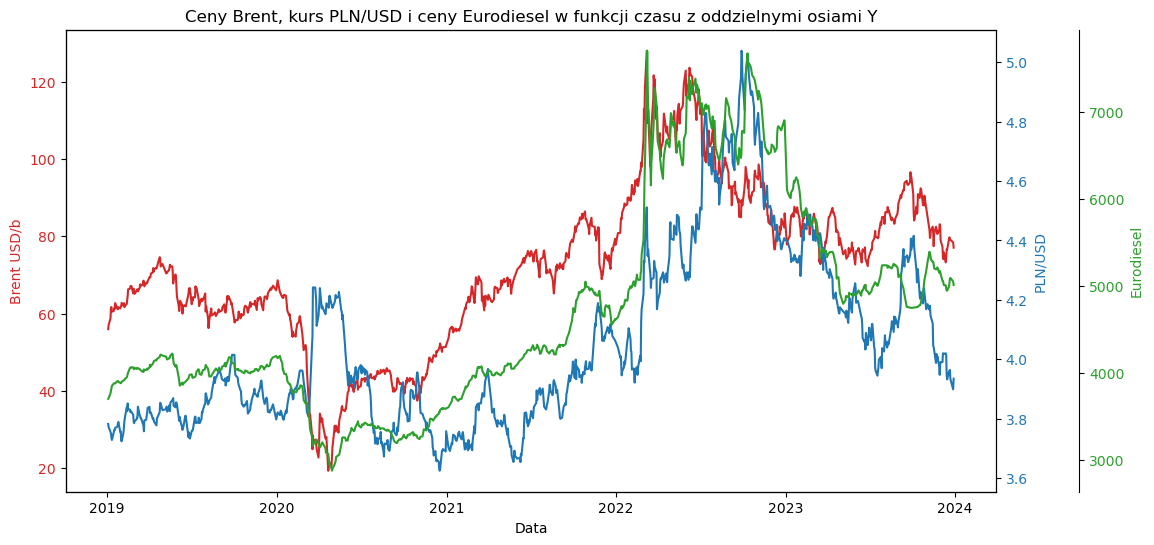

In [90]:
# Tworzenie zbiorczego wykresu danych
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('PLN/USD', color=color)  
ax2.plot(merged_df['PLN/USD'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel', color=color)
ax3.plot(merged_df['Eurodiesel'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent, kurs PLN/USD i ceny Eurodiesel w funkcji czasu z oddzielnymi osiami Y')

plt.show()

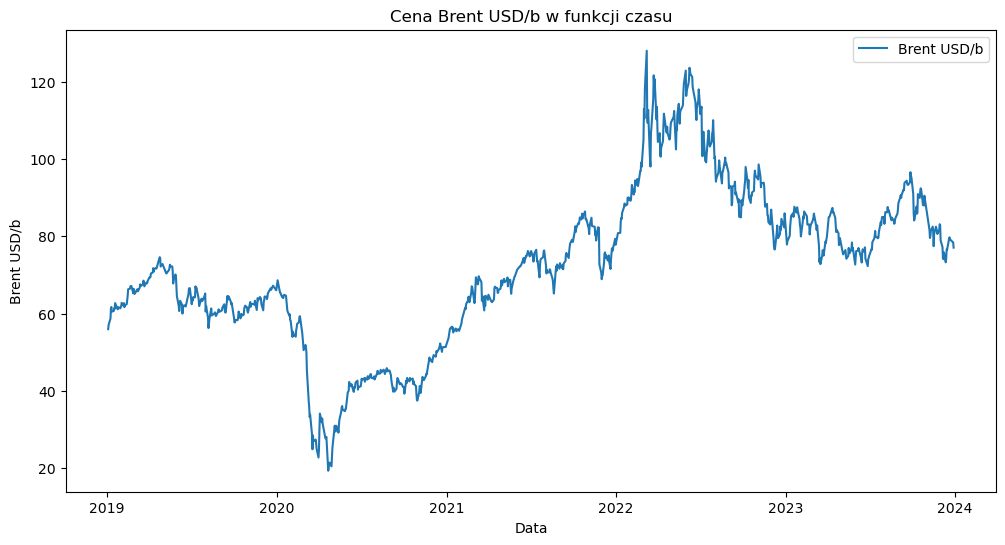

In [91]:
# Wykres dla 'Brent USD/b'
seria = 'Brent USD/b'

plt.figure(figsize=(12, 6))
plt.plot(merged_df[seria], label=seria)

plt.legend()

plt.title(f'Cena {seria} w funkcji czasu')
plt.xlabel('Data')
plt.ylabel(seria)

plt.show()